In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.IndependentCascadesModel as ids

%matplotlib inline

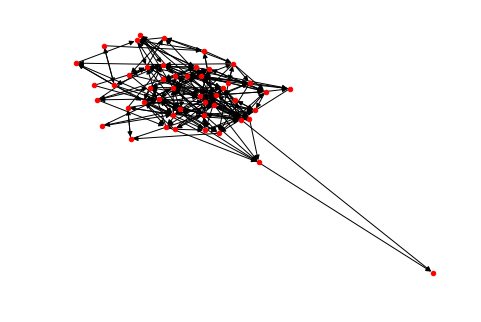

In [2]:
with open('/Users/ewenwang/Documents/practice_data/graph/crem_graphdb_es_20180307.json', 'r') as f:
    data = json.load(f)

source_id = []
target_id = []

for edge in data['data']['edges']:
    source_id.append(edge['source_id'])
    target_id.append(edge['target_id'])

edgelist = [*zip(source_id, target_id)]
G = nx.DiGraph()
G.add_edges_from(edgelist, act_prob=0.2)

nx.draw_spring(G, node_size=20)

In [18]:
G.nodes()

NodeView(('26', '23', '21', '31', '39', '34', '28', '43', '25', '41', '38', '16', '48', '11', '44', '45', '27', '50', '8', '32', '42', '10', '29', '22', '30', '37', '15', '5', '4', '3', '19', '24', '49', '6', '33', '46', '47', '12', '14', '20', '36', '7', '35', '13', '18', '1', '2', '17'))

In [39]:
# Model selection
model = ids.IndependentCascadesModel(G)

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('percentage_infected', 0.1)

# Setting the edge parameters
threshold = 0.1
for e in G.edges():
    config.add_edge_configuration("threshold", e, threshold)

model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(3)

In [41]:
iterations

[{'iteration': 0,
  'node_count': {0: 44, 1: 4, 2: 0},
  'status': {'1': 0,
   '10': 0,
   '11': 1,
   '12': 0,
   '13': 0,
   '14': 0,
   '15': 0,
   '16': 0,
   '17': 0,
   '18': 0,
   '19': 0,
   '2': 0,
   '20': 0,
   '21': 0,
   '22': 0,
   '23': 0,
   '24': 0,
   '25': 0,
   '26': 0,
   '27': 0,
   '28': 1,
   '29': 0,
   '3': 0,
   '30': 0,
   '31': 0,
   '32': 0,
   '33': 1,
   '34': 0,
   '35': 0,
   '36': 0,
   '37': 0,
   '38': 0,
   '39': 1,
   '4': 0,
   '41': 0,
   '42': 0,
   '43': 0,
   '44': 0,
   '45': 0,
   '46': 0,
   '47': 0,
   '48': 0,
   '49': 0,
   '5': 0,
   '50': 0,
   '6': 0,
   '7': 0,
   '8': 0},
  'status_delta': {0: 0, 1: 0, 2: 0}},
 {'iteration': 1,
  'node_count': {0: 43, 1: 0, 2: 5},
  'status': {'11': 2, '14': 2, '28': 2, '33': 2, '39': 2},
  'status_delta': {0: -1, 1: -4, 2: 5}},
 {'iteration': 2,
  'node_count': {0: 43, 1: 0, 2: 5},
  'status': {},
  'status_delta': {0: 0, 1: 0, 2: 0}}]

In [11]:
"""
Implement independent cascade model
"""
#!/usr/bin/env python
#    Copyright (C) 2004-2010 by
#    Hung-Hsuan Chen <hhchen@psu.edu>
#    All rights reserved.
#    BSD license.
#    NetworkX:http://networkx.lanl.gov/.
__author__ = """Hung-Hsuan Chen (hhchen@psu.edu)"""

import copy
import networkx as nx
import random

__all__ = ['independent_cascade']

def independent_cascade(G, seeds, steps=0):
  """Return the active nodes of each diffusion step by the independent cascade
  model

  Parameters
  -----------
  G : graph
    A NetworkX graph
  seeds : list of nodes
    The seed nodes for diffusion
  steps: integer
    The number of steps to diffuse.  If steps <= 0, the diffusion runs until
    no more nodes can be activated.  If steps > 0, the diffusion runs for at
    most "steps" rounds

  Returns
  -------
  layer_i_nodes : list of list of activated nodes
    layer_i_nodes[0]: the seeds
    layer_i_nodes[k]: the nodes activated at the kth diffusion step

  Notes
  -----
  When node v in G becomes active, it has a *single* chance of activating
  each currently inactive neighbor w with probability p_{vw}

  Examples
  --------
  >>> DG = nx.DiGraph()
  >>> DG.add_edges_from([(1,2), (1,3), (1,5), (2,1), (3,2), (4,2), (4,3), \
  >>>   (4,6), (5,3), (5,4), (5,6), (6,4), (6,5)], act_prob=0.2)
  >>> layers = networkx_addon.information_propagation.independent_cascade(DG, [6])

  References
  ----------
  [1] David Kempe, Jon Kleinberg, and Eva Tardos.
      Influential nodes in a diffusion model for social networks.
      In Automata, Languages and Programming, 2005.
  """
  if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
      raise Exception( \
          "independent_cascade() is not defined for graphs with multiedges.")

  # make sure the seeds are in the graph
  for s in seeds:
    if s not in G.nodes():
      raise Exception("seed", s, "is not in graph")

  # change to directed graph
  if not G.is_directed():
    DG = G.to_directed()
  else:
    DG = copy.deepcopy(G)

  # init activation probabilities
  for e in DG.edges():
    if 'act_prob' not in DG[e[0]][e[1]]:
      DG[e[0]][e[1]]['act_prob'] = 0.1
    elif DG[e[0]][e[1]]['act_prob'] > 1:
      raise Exception("edge activation probability:", \
          DG[e[0]][e[1]]['act_prob'], "cannot be larger than 1")

  # perform diffusion
  A = copy.deepcopy(seeds)  # prevent side effect
  if steps <= 0:
    # perform diffusion until no more nodes can be activated
    return _diffuse_all(DG, A)
  # perform diffusion for at most "steps" rounds
  return _diffuse_k_rounds(DG, A, steps)

def _diffuse_all(G, A):
  tried_edges = set()
  layer_i_nodes = [ ]
  layer_i_nodes.append([i for i in A])  # prevent side effect
  while True:
    len_old = len(A)
    (A, activated_nodes_of_this_round, cur_tried_edges) = \
        _diffuse_one_round(G, A, tried_edges)
    layer_i_nodes.append(activated_nodes_of_this_round)
    tried_edges = tried_edges.union(cur_tried_edges)
    if len(A) == len_old:
      break
  return layer_i_nodes

def _diffuse_k_rounds(G, A, steps):
  tried_edges = set()
  layer_i_nodes = [ ]
  layer_i_nodes.append([i for i in A])
  while steps > 0 and len(A) < len(G):
    len_old = len(A)
    (A, activated_nodes_of_this_round, cur_tried_edges) = \
        _diffuse_one_round(G, A, tried_edges)
    layer_i_nodes.append(activated_nodes_of_this_round)
    tried_edges = tried_edges.union(cur_tried_edges)
    if len(A) == len_old:
      break
    steps -= 1
  return layer_i_nodes

def _diffuse_one_round(G, A, tried_edges):
  activated_nodes_of_this_round = set()
  cur_tried_edges = set()
  for s in A:
    for nb in G.successors(s):
      if nb in A or (s, nb) in tried_edges or (s, nb) in cur_tried_edges:
        continue
      if _prop_success(G, s, nb):
        activated_nodes_of_this_round.add(nb)
      cur_tried_edges.add((s, nb))
  activated_nodes_of_this_round = list(activated_nodes_of_this_round)
  A.extend(activated_nodes_of_this_round)
  return A, activated_nodes_of_this_round, cur_tried_edges

def _prop_success(G, src, dest):
  return random.random() <= G[src][dest]['act_prob']

In [38]:
independent_cascade(G, seeds=['17', '1', '10', '3'], steps=3)

[['17', '1', '10', '3'],
 ['26', '30', '2', '50', '29'],
 ['39', '44', '11', '31'],
 ['27', '45', '32', '21']]